# Assignment 5

Explore embeddings and CNN

Using tweeter dataset ( https://www.kaggle.com/utathya/sentiment-analysis-of-imdb-reviews/data) and already existing splitting on train/test sets, develop a model for sentiment analysis.  
Your quality metric is crossentropy (`sklearn.metrics.log_loss`, `torch.nn.CrossEntropy`)  

Your model should be based on CNN and written in pytorch `torch.nn.Conv1d`.

Explore 3 ways, which of them has better perfomance on test set?:
1. Using pretrained word embeddings with frozen weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=True)`.
You can download any pretrained embeddings you like.
2. Train embeddings yourself, initializing from pretrained weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=False)`
3. Train embeddings yourself with random initialization `torch.nn.init.uniform_(nn.Embeddings.weights)`

Experiment with model arhitecture (as bonus):
1. activation functions RELU, ELU, etc `torch.nn.functional.relu, torch.nn.functional.elu`  
1. Stack layers
1. max or average pooling (`torch.nn.functional.max_pool1d, torch.nn.functional.avg_pool1d`)
1. Dropout


Other requirements:
1. Your training routine should use any learning scheduler (torch.nn.optim.lr_scheduler).  
Plot current learning rate against number of epochs, e.g. `tt.optim.Adam.param_groups[0]['lr']`.  

1. Your training routine should use early stopping on validation dataset
Use hold out validation scheme in your experiments.

1. You should use torchtext for parsing 

**Note**:
This assignment has no baseline. Instead, **validation curves** for explored architectures are expected.  
Validation curve is plot of model test score against model hyperparameter value.  
example (https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html) . 
Though, using `sklearn.model_selection.validation_curve` is not necessary.  






In [9]:
from sklearn.metrics import log_loss
from torch import nn
from torch import optim
import torch as tt
from sklearn.model_selection import validation_curve
import pandas as pd
from nltk.corpus import stopwords
import string
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator
import nltk
import torch.nn.functional as F

SEED = 42
np.random.seed(SEED)

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nikita\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [10]:
df_master = pd.read_csv(r'imdb_master.csv', encoding='latin-1', index_col = 0)
df_master.to_csv(r'imdb_master.csv', encoding='utf-8')

In [11]:
df_master[df_master['type'] == 'test'].to_csv(r'test.csv', encoding='utf-8')
df_master[df_master['type'] == 'train'].to_csv(r'train.csv', encoding='utf-8')

In [15]:
#import spacy

#nlp = spacy.load('en')

def tokenizer(text): # create a tokenizer function
    return [tok for tok in text.split() if tok.isalpha()]

In [18]:
classes={'neg': 0, 'pos': 1, 'unsup': 2}


TEXT = Field(include_lengths=True, batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=nltk.corpus.stopwords.words('english'))
LABEL = LabelField(dtype=tt.int64, use_vocab=True, preprocessing=lambda x: classes[x])


dataset = TabularDataset('imdb_master.csv', format='csv',
                         fields=[(None, None), (None, None),('text', TEXT), ('label', LABEL), (None, None)], 
                         skip_header=True)

train = TabularDataset('train.csv', format='csv',
                         fields=[(None, None), (None, None),('text', TEXT), ('label', LABEL), (None, None)], 
                         skip_header=True)

test = TabularDataset('test.csv', format='csv',
                         fields=[(None, None), (None, None),('text', TEXT), ('label', LABEL), (None, None)], 
                         skip_header=True)

In [19]:
TEXT.build_vocab(dataset, min_freq=10, vectors="glove.6B.100d")
len(TEXT.vocab.itos)

.vector_cache\glove.6B.zip: 862MB [05:08, 2.79MB/s]                            
100%|███████████████████████████████▉| 399497/400000 [01:13<00:00, 5435.24it/s]

31921

100%|███████████████████████████████▉| 399497/400000 [01:30<00:00, 4435.10it/s]

In [20]:
LABEL.build_vocab(dataset)

In [21]:
train, valid = train.split(0.7, stratified=True)

In [24]:
len(TEXT.vocab.vectors)

31921

#### Зададим модель

In [25]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, embed_matrix, hidden_size, kernels, mode, n_epochs=5):
        super(MyModel, self).__init__()
        if mode == 'pretrained':
            self.embedding = nn.Embedding.from_pretrained(embed_matrix, freeze=True)
        elif mode == 'weights':
            self.embedding = nn.Embedding.from_pretrained(embed_matrix, freeze=False)
        elif mode == 'random':
            self.embedding = nn.Embedding.from_pretrained(nn.init.uniform_(tt.ones((vocab_size,100))), freeze=False)
            
        self.n_epochs = n_epochs
        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
        
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        
    def forward(self, x):
        
        x = self.embedding(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        return x
    
    
    def train_nn(self):
        min_loss = np.inf
        no_improvement = 0
        lr_list = list()
        for i in range(self.n_epochs):
            train_loss = 0
            for batch in train_iterator:
                optimizer.zero_grad()
                y_pred = self.forward(batch.text[0])
                loss = criterion(y_pred, batch.label)
                train_loss += loss
                loss.backward()
                optimizer.step()
            train_loss = train_loss / len(train_iterator)
            
            val_loss_vols = 0
            with tt.no_grad():
                for batch in valid_iterator:
                    val_pred = self.forward(batch.text[0])
                    val_loss = criterion(val_pred, batch.label)
                    val_loss_vols += val_loss
            val_loss = val_loss_vols / len(valid_iterator)
            
            scheduler.step(val_loss)
            lr_list.append(optimizer.param_groups[0]['lr'])
            
            if val_loss < min_loss:
                min_loss = val_loss
                no_improvement = 0
            elif no_improvement < 10:
                no_improvement += 1
            else:
                break
                
            print(f'| Epoch: {i+1:02} | Train Loss: {train_loss:.3f} | Val. Loss: {val_loss:.3f} |')
    
        return lr_list
    
    def evaluate(self, test_iterator, criterion):
        epoch_loss = 0
        with tt.no_grad():
                for batch in test_iterator:
                    test_pred = self.forward(batch.text[0])
                    test_loss = criterion(test_pred, batch.label)
                    epoch_loss += test_loss
                    
        return epoch_loss / len(test_iterator)

In [26]:
tt.cuda.empty_cache()

batch_size = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.text)
)

In [27]:
model = MyModel(len(TEXT.vocab.itos),
                embed_size=100,
                embed_matrix=TEXT.vocab.vectors,
                hidden_size=128,
                kernels=[2,3,4,5],
                mode='pretrained',
                n_epochs=2
               )


optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=False, cooldown=5)
criterion = nn.CrossEntropyLoss()

In [28]:
lr = model.train_nn()

| Epoch: 01 | Train Loss: 0.834 | Val. Loss: 0.950 |
| Epoch: 02 | Train Loss: 0.821 | Val. Loss: 0.894 |


In [29]:
losses = list()
lr_all = list()

for mode in ['random', 'pretrained', 'weights']:
    
    tt.cuda.empty_cache()
    
    model = MyModel(len(TEXT.vocab.itos),
                embed_size=100,
                embed_matrix=TEXT.vocab.vectors,
                hidden_size=128,
                kernels=[2,3,4,5],
                mode=mode,
                n_epochs=100
               )
    
    optimizer = optim.Adam(model.parameters())
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=False, cooldown=5)
    criterion = nn.CrossEntropyLoss()

    lr = model.train_nn()
    lr_all.append(lr)
    
    test_loss = model.evaluate(test_iterator, criterion)
    losses.append(test_loss)
    
    print(f' Test Loss: {test_loss:.3f}')

| Epoch: 01 | Train Loss: 0.874 | Val. Loss: 0.836 |
| Epoch: 02 | Train Loss: 0.796 | Val. Loss: 1.088 |
| Epoch: 03 | Train Loss: 0.729 | Val. Loss: 1.153 |
| Epoch: 04 | Train Loss: 0.665 | Val. Loss: 1.403 |
| Epoch: 05 | Train Loss: 0.593 | Val. Loss: 1.447 |
| Epoch: 06 | Train Loss: 0.486 | Val. Loss: 1.947 |
| Epoch: 07 | Train Loss: 0.465 | Val. Loss: 2.084 |
| Epoch: 08 | Train Loss: 0.454 | Val. Loss: 2.176 |
| Epoch: 09 | Train Loss: 0.444 | Val. Loss: 2.277 |
| Epoch: 10 | Train Loss: 0.431 | Val. Loss: 2.363 |
| Epoch: 11 | Train Loss: 0.422 | Val. Loss: 2.424 |
 Test Loss: 5.684
| Epoch: 01 | Train Loss: 0.834 | Val. Loss: 0.916 |
| Epoch: 02 | Train Loss: 0.821 | Val. Loss: 0.933 |
| Epoch: 03 | Train Loss: 0.819 | Val. Loss: 0.919 |
| Epoch: 04 | Train Loss: 0.817 | Val. Loss: 1.013 |
| Epoch: 05 | Train Loss: 0.817 | Val. Loss: 1.048 |
| Epoch: 06 | Train Loss: 0.810 | Val. Loss: 0.962 |
| Epoch: 07 | Train Loss: 0.810 | Val. Loss: 0.970 |
| Epoch: 08 | Train Loss: 0.

In [31]:
from matplotlib import pyplot as plt
% matplotlib inline

Learning rate against the number of epoch

Text(0.5,1,'Learning rate against the number of epoch')

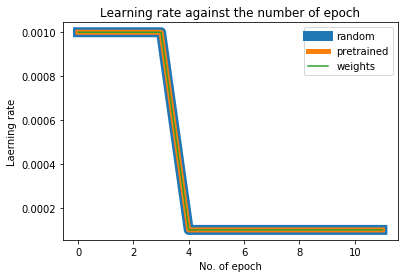

In [46]:
plt.plot(range(0, len(lr_all[0])), lr_all[0], label = 'random', linewidth=10)
plt.plot(range(0, len(lr_all[1])), lr_all[1], label = 'pretrained', linewidth=5)
plt.plot(range(0, len(lr_all[2])), lr_all[2], label = 'weights')
plt.legend()
plt.xlabel('No. of epoch')
plt.ylabel('Laerning rate')
plt.title('Learning rate against the number of epoch')

Validation Curve

Text(0.5,1,'Validation Curve')

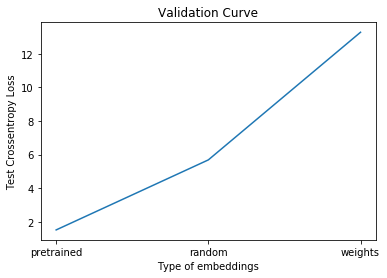

In [43]:
plt.plot(['pretrained', 'random', 'weights'], [losses[1], losses[0], losses[2]])
plt.xlabel('Type of embeddings')
plt.ylabel('Test Crossentropy Loss')
plt.title('Validation Curve')